Import packages and codes to be used 


In [1]:
%matplotlib inline
import numpy as np
import sympy as sp
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
#Import Boundary.py where the boundary geometric features are defined
from Boundary import *

Define the domain

In [2]:
t = sp.Symbol('t')

#circle
fsym = (2*sp.cos(t), 2*sp.sin(t))

#ellipse
#fsym = (4*sp.cos(t), sp.sin(t))

#star
#a = 0.3 
#w = 5
#frad = 1 + a * sp.cos( w * t )
#fsym = (frad*sp.cos(t), frad*sp.sin(t))

#kite
#fsym = (sp.cos(t) + 0.65 * sp.cos(2*t) - 0.65, 1.5 * sp.sin(t))

f = Boundary(fsym)
lclassB(f)

Discretization

In [3]:
#Note to compare to the DLP formulation - N = 2*NN and we should use the same N value in both
NN = 64  
N = 2*NN
L = 2*np.pi
dt = L/N
t = np.linspace(0, L, N, endpoint=False) 

y0 = f.y_l(t)[0]
y1 = f.y_l(t)[1]
J = f.J_l(t)
κ = f.κ_l(t)
n0 = f.ν_l(t)[0]
n1 = f.ν_l(t)[1]


Plot the domain 

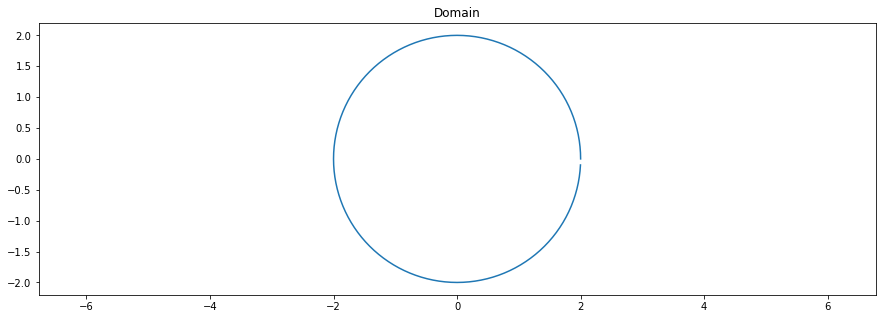

In [4]:
fig, (ax1) = plt.subplots(1, 1, figsize=(15,5))
ax1.set_title('Domain')
ax1.axis('equal')
ax1.plot(y0,y1)

Solving the BIE

87.33654475055394
5.7267471445654904e+16


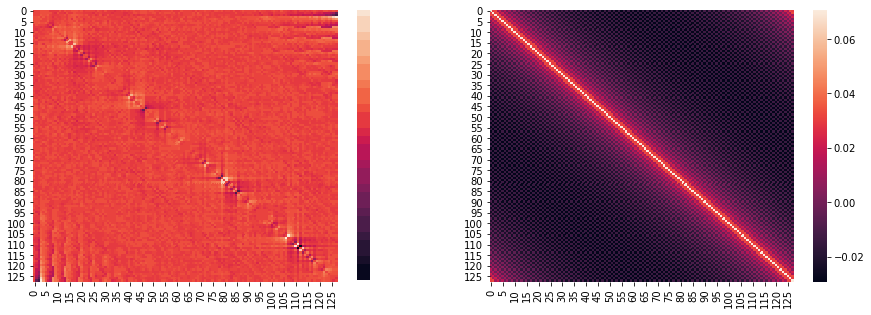

In [5]:
kernel1 = np.full((N,N), np.nan)
kernel2 = np.full((N,N), np.nan)
g = np.full((N,1), np.nan)
Rjminusin = np.full((N+N-1,1),np.nan) 
mu_per = np.full((N+1,1), np.nan)
t_per = np.full((N+1,1), np.nan)


#compute Rjminusin vector
for i in range (0, N+N-1):
    Rjminusin[i] = 0.0
    Ri = i - (2*NN - 1)
    for k in range (1, NN):
        Rjminusin[i] = Rjminusin[i] - np.cos(k*Ri*np.pi/NN)/k - (-1.0)**(Ri)/2/NN 
    Rjminusin[i] = Rjminusin[i]/NN 
        
for i, ti in enumerate(t):
    #g[i] = 1.0
    g[i] = np.exp(y0[i])*np.cos(y1[i])
    for j, ti in enumerate(t):   
        rdiff = [y0[i] - y0[j], y1[i] - y1[j]]
        r_distance_2 = (rdiff[0]**2 + rdiff[1]**2)
        Rindex = j - i + 2*NN - 1 
        kernel2[i,j] = J[j] * Rjminusin[Rindex]
        if i != j:
            kernel1[i,j] = J[j] * np.log( ( 4.0*(np.sin( (t[i]-t[j])/2.0 ))**2 ) / r_distance_2 )
        else:
            kernel1[i,j] = J[i] * np.log( 1.0 / (J[i]**2) )                
A = (kernel1 / (2*N)) - (kernel2 / 2)
μ = np.linalg.solve(A, g)

#Condition number of the matrix A
print(np.linalg.cond(A))
print(np.linalg.cond(kernel2))

for i in range(0, N):
    mu_per[i] = μ[i]
    t_per[i] = t[i]
mu_per[N] = μ[0] 
t_per[N] = L

#Heatmaps of matrices of kernel
fig = plt.figure(figsize=(15,5))
ax1 = fig.add_subplot(121)
sns.heatmap(kernel1,ax = ax1)
ax2 = fig.add_subplot(122)
sns.heatmap(A,ax = ax2)

Plot the density 

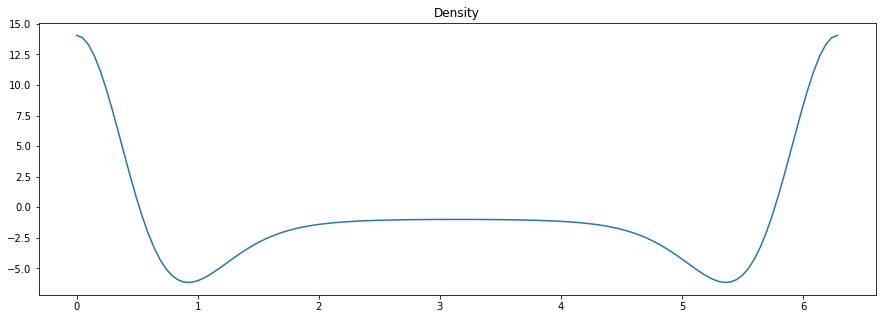

In [6]:
fig, (ax1) = plt.subplots(1, 1, figsize=(15,5))
ax1.set_title('Density')
ax1.plot(t_per,mu_per)

Solving for the solution

In [ ]:
M = 100
r = np.linspace(2, 0.0001, M)
x0 = np.full((M,N), np.nan)
x1 = np.full((M,N), np.nan)
u = np.full((M,N), np.nan)
erroru = np.full((M,N), np.nan)
exactu = np.full((M,N), np.nan)

x0_per = np.full((M,N+1), np.nan)
x1_per = np.full((M,N+1), np.nan)
u_per = np.full((M,N+1), np.nan)
erroru_per = np.full((M,N+1), np.nan)
exactu_per = np.full((M,N+1), np.nan)

for i, ri in enumerate(r):
    for j, tj in enumerate(t):  
        #Compute x values at where the solution will be evaluated
        x0[i,j] = y0[j] - n0[j]*r[i]
        x1[i,j] = y1[j] - n1[j]*r[i]
        u[i,j] = 0 
        
        for k, tk in enumerate(t):
            rdiff = [x0[i,j] - y0[k], x1[i,j] - y1[k]]
            r_distance_2 = (rdiff[0]**2 + rdiff[1]**2)
            u[i,j] = u[i,j] - J[k] * μ[k] * np.log(r_distance_2) / (2*N)
           
        exactu[i,j] = np.exp(x0[i,j])*np.cos(x1[i,j])
        #exactu[i,j] = 1
        erroru[i,j] = np.abs(exactu[i,j]-u[i,j])

print(np.max(erroru))

#Make the solution periodic for plotting
for i in range(0, M):
    for j in range(0, N): 
        x0_per[i,j] = x0[i,j] 
        x1_per[i,j] = x1[i,j]
        u_per[i,j] = u[i,j]
        erroru_per[i,j] = erroru[i,j]
        exactu_per[i,j] = exactu[i,j]
        
    x0_per[i,N] = x0[i,0]
    x1_per[i,N] = x1[i,0]
    u_per[i,N] = u[i,0]
    erroru_per[i,N] = erroru[i,0]
    exactu_per[i,N] = exactu[i,0]
        

Plot Solution 

In [ ]:
fig = plt.figure(figsize=(15,5))
ax1 = fig.add_subplot(121)
umin = np.min(exactu)
umax = np.max(exactu)
fig1 = plt.pcolor(x0_per, x1_per, u_per,vmin=umin,vmax = umax)
ax1.axis('equal')
fig.colorbar(fig1)
ax1.set_title('Numerical Solution')

ax2 = fig.add_subplot(122)
fig2 = plt.pcolor(x0_per, x1_per, exactu_per,vmin=umin,vmax = umax)
ax2.axis('equal')
fig.colorbar(fig2)
ax2.set_title('Exact Solution')

Plot Error

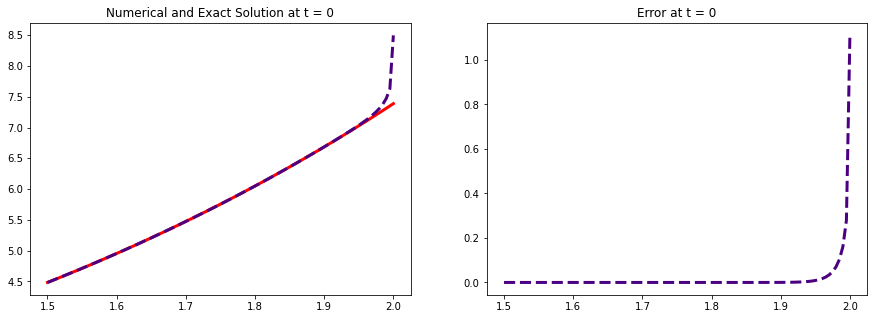

In [9]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(15,5))
ax1.set_title('Numerical and Exact Solution at t = 0')
ax1.plot(x0[:,0],exactu[:,0],color='Red', linestyle='-', linewidth=3)
ax1.plot(x0[:,0],u[:,0],color='Indigo', linestyle='--', linewidth=3)
ax2.set_title('Error at t = 0')
ax2.plot(x0[:,0],erroru[:,0],color='Indigo', linestyle='--', linewidth=3)


<ipython-input-10-a84ea64040e5>:3: RuntimeWarning: divide by zero encountered in log
  fig1 = plt.pcolor(x0, x1, np.log(erroru),vmin=-16,vmax =0)
<ipython-input-10-a84ea64040e5>:9: RuntimeWarning: divide by zero encountered in log
  fig2 = plt.pcolor(x0_per, x1_per, np.log(erroru_per),vmin=-16,vmax =0)


Text(0.5, 1.0, 'Error')

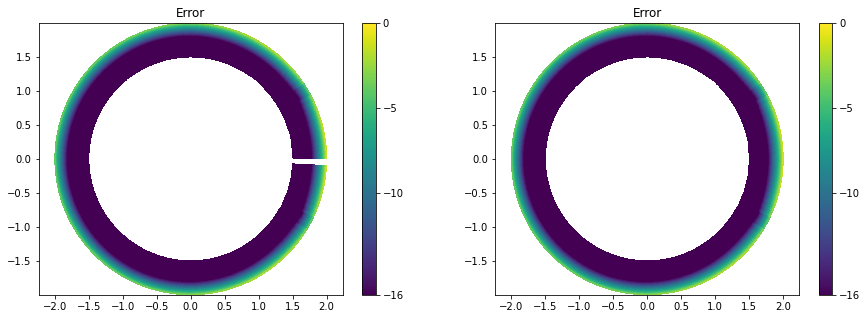

In [10]:
fig = plt.figure(figsize=(15,5))
ax1 = fig.add_subplot(121)
fig1 = plt.pcolor(x0, x1, np.log(erroru),vmin=-16,vmax =0)
ax1.axis('equal')
fig.colorbar(fig1,ticks=[-16,-10,-5,0])
ax1.set_title('Error')

ax2 = fig.add_subplot(122)
fig2 = plt.pcolor(x0_per, x1_per, np.log(erroru_per),vmin=-16,vmax =0)
ax2.axis('equal')
fig.colorbar(fig2,ticks=[-16,-10,-5,0])
ax2.set_title('Error')
